### Quickstart Tutorial

#### 1.1 Fast Light Curves

As a simple first example, we will use $\texttt{eleanor}$ to create a target pixel file (TPF) and light curve for a given TIC target.

In [1]:
from IPython.display import Image

In [2]:
import eleanor
import numpy as np
import matplotlib.pyplot as plt

First, we will load the data for TIC 38846515 (WASP-100), a relatively bright star observed in Sector 1. $\texttt{eleanor}$ is able to extract a light curve easily and automatically for this unblended object. Calling source will assign a $\textit{Gaia}$ ID, TESS magnitude, sector, camera, ccd, and associated postcard.

In [3]:
star = eleanor.Source(tic=38846515, sector=1, tc=True)

Here, `tc=True` tells the software to go download a postcard-like object with TessCut, which will enable us to access data for stars observed in any sector, or as we will see later, in multiple sectors. 

We can also pass through a Gaia DR2 ID or RA/Dec pair, either as a tuple or an Astropy SkyCoord object. For example, the following three calls all point to the same target:

In [5]:
star = eleanor.Source(tic=38846515, sector=1, tc=True)

print('Found TIC {0} (Gaia {1}), with TESS magnitude {2}, RA {3}, and Dec {4}'
     .format(star.tic, star.gaia, star.tess_mag, star.coords[0], star.coords[1]))

star = eleanor.Source(coords=(68.959732, -64.02704), sector=1, tc=True)

print('Found TIC {0} (Gaia {1}), with TESS magnitude {2}, RA {3}, and Dec {4}'
     .format(star.tic, star.gaia, star.tess_mag, star.coords[0], star.coords[1]))

star = eleanor.Source(gaia=4675352109658261376, sector=1, tc=True)

print('Found TIC {0} (Gaia {1}), with TESS magnitude {2}, RA {3}, and Dec {4}'
     .format(star.tic, star.gaia, star.tess_mag, star.coords[0], star.coords[1]))

Found TIC 38846515 (Gaia 4675352109658261376), with TESS magnitude 10.3157, RA 68.9597092399964, and Dec -64.0270368810381
Inflating...
Found TIC 38846515 (Gaia 4675352109658261376), with TESS magnitude 10.3157, RA 68.959732, and Dec -64.02704
Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Inflating...
Found TIC 38846515 (Gaia 4675352109658261376), with TESS magnitude 10.3157, RA 68.95981586357303, and Dec -64.02703903114245


Gaia has quite a bit of precision on the star's position! Now that we have our `Source` information, we simply call the `TargetData()` function, which will extract a target pixel file, perform aperture photometry with an automatically optimized aperture choice, and complete some simple systematics corrections.

In [6]:
data = eleanor.TargetData(star, height=15, width=15, bkg_size=31, do_psf=True, do_pca=True)


W1011 14:47:16.230411 4482774464 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/eleanor/targetdata.py:697: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

W1011 14:47:16.231087 4482774464 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/eleanor/targetdata.py:697: The name tf.logging.ERROR is deprecated. Please use tf.compat.v1.logging.ERROR instead.

100%|██████████| 1282/1282 [00:10<00:00, 120.26it/s]


$\texttt{eleanor}$ may download a file here (if `tc=False`). Don't be afraid of this download. We have created an intermediate step between FFIs and TPFs called $\textbf{postcards}$. In order to create a TPF, $\texttt{eleanor}$ downloads the postcard your source falls on. We'll talk through the flags you can set, but let's look at a light curve first.

Text(0.5, 0, 'Time')

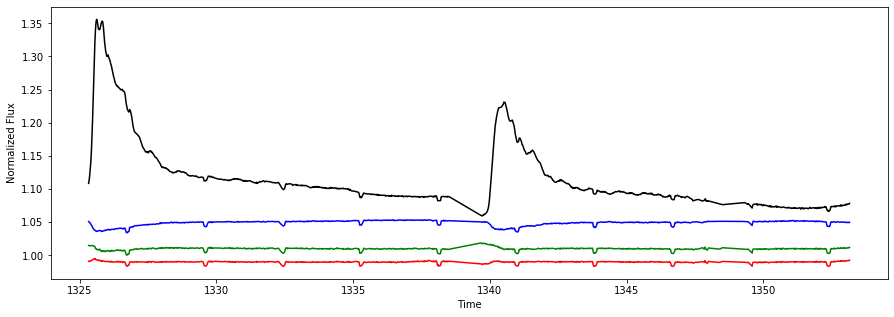

In [15]:
plt.figure(figsize=(15,5))

q = data.quality == 0

plt.plot(data.time[q], data.raw_flux[q]/np.median(data.raw_flux[q])+0.1, 'k')
plt.plot(data.time[q], data.corr_flux[q]/np.median(data.corr_flux[q]) - 0.01, 'r')
plt.plot(data.time[q], data.pca_flux[q]/np.median(data.pca_flux[q]) + 0.01, 'g')
plt.plot(data.time[q], data.psf_flux[q]/np.median(data.psf_flux[q]) + 0.05, 'b')
plt.legend
plt.ylabel('Normalized Flux')
plt.xlabel('Time')


There's a planet there! We can see the raw flux has significant background flux which is effectively being removed in the other time series. What does our aperture look like?

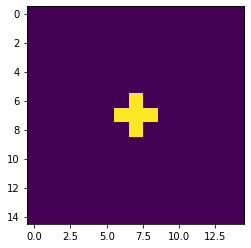

In [8]:
plt.imshow(data.aperture)

Let's save these data to a FITS file so we have them later. By default, this will be saved to a `~/.eleanor` directory, but that can be changed by setting a `directory`.

In [9]:
data.save()

W1011 14:47:28.857093 4482774464 logger.py:200] VerifyWarning: Card is too long, comment will be truncated.


#### 1.2 Custom Apertures

That was easy! But what if you're not satisfied with $\texttt{eleanor}$'s default choice of aperture? Well, we provide you with two ways to create your own aperture.

(1) $\texttt{eleanor}$ can help you create your own mask. By calling custom_aperture, you can choose from a circular or rectangular aperture. You can also choose the size (radius or length x width) and the pixel the aperture is centered on. The aperture will only be created on pixels within the TPF (it won't spill over to other pixels)

In [10]:
eleanor.TargetData.custom_aperture(data, shape='circle', r=1)
eleanor.TargetData.get_lightcurve(data)

TypeError: 'ApertureMask' object is not subscriptable

(2) You can pass in your own mask. Create a 2D array of the same shape as your TPF and pass in the aperture using the following command

In [ ]:
mask = np.zeros(np.shape(data.tpf[0]))
mask[6:8,6:8] = 1
plt.imshow(mask, origin='lower')
data.get_lightcurve(aperture=mask)

With one line of code, we can pass this through as a [lightkurve](https://github.com/KeplerGO/lightkurve) object and begin using the functionality of that package. 

In [ ]:
from lightkurve.lightcurve import LightCurve as LC

lk = LC(data.time[q], data.corr_flux[q]).plot()

##### 1.2.1 Vetting your light curve at the pixel level

We have created a user-friendly method to analyzing your light curve at the pixel level to look for any odd features that might affect only a few pixels.

In [ ]:
vis = eleanor.Visualize(data)
vis.pixel_by_pixel(rowrange=[5,11], colrange=[5,11])

This function call produces a light curve for every pixel, plotted in the same orientation as the TPF cutout requested. Here, we can see the transit events appear to fall on the central pixels, where the star is brightest. This might be a real planet, on the star we think it is on!

#### 1.3 Systematics Corrections

When we called eleanor.TargetData() in 1.1, some simple systematics corrections were automatically performed on the light curve. Let's apply those explicitly to the newly created raw light curve from the custom aperture.

In [ ]:
corr_flux = eleanor.TargetData.corrected_flux(data, flux=data.raw_flux)

In [ ]:
plt.plot(data.time[q], corr_flux[q], 'k.')

plt.ylabel('Flux')
plt.xlabel('Time')

We can then run pca with this flux time series to remove any shared systematics with nearby stars.

In [ ]:
data.corrected_flux(flux=corr_flux, modes=4, pca=True)

In [ ]:
plt.plot(data.time[q], data.pca_flux[q], 'k.')
plt.ylabel('Flux')
plt.xlabel('Time')

PSF modeling is always an option too!

In [ ]:
eleanor.TargetData.psf_lightcurve(data, model='gaussian')

In [ ]:
lk = LC(data.time[q], data.psf_flux[q]).plot()

We also could have used a Moffat profile, or passed through our own data or uncertainty array. There is quite a bit of flexibility in how the PSF models are fit, as described in the docs.

#### 1.4 Stars Observed in Multiple Sectors

$\texttt{eleanor}$ has some built-in tools to make it easier to work with stars that are observed in multiple TESS sectors. Let's consider WASP-100 again, which was observed in both Sectors 1 and 2. When we previously called `eleanor.Source()`, we can instead call `eleanor.multi_sectors()`, which will make a list of Source objects for all sectors requested.

In [ ]:
star = eleanor.multi_sectors(tic=38846515, sectors=[1,2], tc=True)

In this case, I only wanted sectors 1 and 2. However, I could have passed through `sectors=all` to get all sectors in which this star was observed.

In [ ]:
print(star)

Yep, it's a list of objects!
We can then call `eleanor.TargetData()` on each.

In [ ]:
data0 = eleanor.TargetData(star[0], height=15, width=15, bkg_size=31, do_psf=False, do_pca=False)
data1 = eleanor.TargetData(star[1], height=15, width=15, bkg_size=31, do_psf=False, do_pca=False)

q0 = data0.quality == 0
q1 = data1.quality == 0

plt.plot(data0.time[q0], data0.corr_flux[q0]/np.median(data0.corr_flux[q0]), 'k.')
plt.plot(data1.time[q1], data1.corr_flux[q1]/np.median(data1.corr_flux[q1]), 'r.')

plt.ylabel('Normalized Flux')
plt.xlabel('Time')

plt.show()

If you are only interested in one Sector your star was observed in, you can call `eleanor.Source(sector=1)` and specify the Sector you are interested in. If your star was observed in multiple sectors and you call `eleanor.Source()`, it will return the light curve from the most recent Sector the star was observed in.

#### 1.5 Good practices

We're still exploring what the best practices are generally. Good practices seem to differ across the detector, but here's what we believe so far. If you discover anything that works well for you, we and other $\texttt{eleanor}$ users would surely love to know them!

Good background subtraction is very important. The size of the region to use for an "ideal" background changes across the detector. Generally, bigger is better, we typically recommend using a region larger than the standard TPF. Currently, the background used must be a rectangle centered on the star, with size `bkg_size`

PSF modeling (`do_psf=True`) seems to work very well for relatively bright, isolated stars. Presently the only PSF model is a Gaussian, but both Gaussian and Poisson likelihood functions are possible. Do note that this requires tensorflow. Note that PSF modeling is very much in beta and our current implementation has known issues for very faint stars (fainter than I ~ 15, generally).

If you find anything that works well for your science, or uncover any issues, please let us know! Github [issues](https://github.com/afeinstein20/eleanor/issues) or [pull requests](https://github.com/afeinstein20/eleanor/pulls) are welcomed.